<a href="https://colab.research.google.com/github/jhlee508/handson-ml2-study/blob/master/HoM_Ch15_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# **15.3 시계열 예측하기**
- RNN 모델을 이용해 예측할 시계열을 임의로 만들어보자.

In [17]:
# 임의의 단변량 시계열 생성 함수
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1) # 랜덤 균등분포
    time = np.linspace(0, 1, n_steps) # 타입 스텝 길이의 직선
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   사인곡선 1 
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 사인곡선 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

(3, 10, 1)


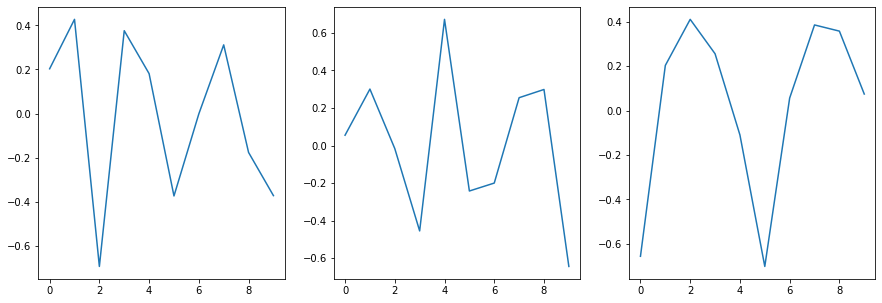

In [18]:
# 생성된 단변량 시계열 예시로 그려보기
batch_size_test = 3
time_step_test = 10

series_test = generate_time_series(batch_size_test, time_step_test)
print(series_test.shape)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axes[i].plot(series_test[i, :, :])
plt.show()

In [19]:
n_steps = 50 # 타임 스텝 수 = 50

series = generate_time_series(10000, n_steps + 1) # 배치 크기 = 10000, 타임 스텝 수 = 50 + '1'
series.shape

(10000, 51, 1)

In [20]:
X_train, y_train = series[:7000, :n_steps], series[:7000, -1] # time_step = 50, time_step = 1
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [21]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [22]:
X_valid.shape, y_valid.shape

((2000, 50, 1), (2000, 1))

In [23]:
X_test.shape, y_test.shape

((1000, 50, 1), (1000, 1))

## **15.3.1 기준 성능(Baseline Performance)**
기준 성능을 준비해야 모델의 성능을 판단할 수 있다.

### 순진한(단순한) 예측

마지막 값을 예측, 실제(다음) 값과 비교



In [24]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020308906

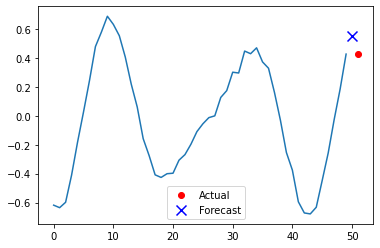

In [25]:
plt.plot(X_valid[0, :, 0]) # X_valid 첫 번째 시계열 데이터 그리기

plt.scatter(n_steps + 1, y_pred[0, 0], c = 'r', label="Actual") # 실제 값
plt.scatter(n_steps, y_valid[0, 0],marker = 'x', s = 100, c = 'b', label="Forecast") # y_valid 예측 값(마지막 값)
plt.legend(fontsize=10)
plt.show()

### 선형 회귀 모델 예측

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer="adam")

model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.2222 - val_loss: 0.0486
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0368 - val_loss: 0.0178
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0144 - val_loss: 0.0102
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0079
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0047

In [27]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 797us/step - loss: 0.0039


0.003879386465996504

## **15.3.2 간단한 RNN 구현하기**

### Simple RNN 모델
- 하나의 뉴런(하나의 층)으로 이루어진 RNN 모델
- tanh 활성화 함수 사용
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN?version=nightly

In [28]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) # 입력 시퀀스 길이 지정 필요 없음
])
print(model.summary())

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0305 - val_loss: 0.0197
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0177 - val_loss: 0.0132
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 6/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 7/20
219/219 [=============================

In [29]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0108


0.010841252282261848

## **15.3.3 Deep RNN**
- 셀을 여러 층으로 쌓은 심층 RNN 모델
- 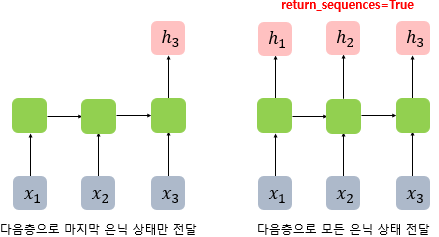
- 이미지 출처: https://wikidocs.net/22886

In [30]:
# return_sequence 파라미터의 역할
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(1, input_shape=(3, 1), return_sequences=True))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 3, 1)              3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [31]:
# SimpleRNN(유닛 또는 은닉 상태의 크기 = 20)에서 '20'은 출력 차원의 수와 같다
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
print(model.summary())

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, None, 20)          440       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 20)          820       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 1)                 22        
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
219/219 [==============================] - 7s 25ms/step - loss: 0.2640 - val_loss: 0.0118
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 4/20
219/219 [==============================] - 5s 23ms/step - loss:

In [32]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 6ms/step - loss: 0.0035


0.003452492877840996

### 마지막 층의 은닉 상태 제거
- Dense Layer 사용
- 새로운 활성화 함수 사용 가능

In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # return_sequences 제거 -> 은닉 상태 제거
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0700 - val_loss: 0.0064
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0029 - val_lo

In [34]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0030


0.003029847051948309

## **15.3.4 여러 타임 스텝 앞을 예측하기**

### 한 번에 1 스텝 씩 10 스텝 앞을 예측하기

In [35]:
series = generate_time_series(1, n_steps + 10) # 타임 스텝 + 10

# 새로운 X, Y 생성
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new

# 하나의 값을 예측하는 모델으로 하나의 값씩 총 10개 예측
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [36]:
Y_pred, Y_pred.shape

(array([[[-0.50744313],
         [-0.575391  ],
         [-0.5765375 ],
         [-0.5429195 ],
         [-0.48491862],
         [-0.41630238],
         [-0.3270614 ],
         [-0.2009494 ],
         [-0.0460524 ],
         [ 0.12812048]]], dtype=float32), (1, 10, 1))

In [37]:
np.mean(keras.metrics.mean_squared_error(Y_new, Y_pred))

0.019333148

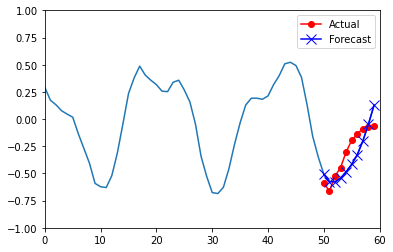

In [41]:
plt.plot(X[0, :, 0])
plt.plot(np.arange(n_steps, n_steps + 10), Y_new[0, :, 0], "ro-", label="Actual")
plt.plot(np.arange(n_steps, n_steps + 10), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
plt.axis([0, n_steps + 10, -1, 1])
plt.legend(fontsize=10)
plt.show()

### 다음 값 10개를 한 번에 예측
- 50개의 타임 스텝을 이용하여 다음 10개의 타임 스텝 값 예측
-  0 ~ 49  =>  50 ~ 59 

In [75]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10) # 타임 스텝 + 10
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0] # Y 타깃을 마지막 10개의 값으로 설정
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [76]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0970 - val_loss: 0.0302
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0268 - val_loss: 0.0189
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0187 - val_loss: 0.0167
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0141 - val_loss: 0.0142
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0134 - val_loss: 0.0137
Epoch 7/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0123 - val_loss: 0.0116
Epoch 8/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0127 - val_loss: 0.0111
Epoch 9/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0114 - val_loss: 0.0118
Epoch 10/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0113 - val_lo

In [77]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0096


0.009643549099564552

### 모든 타임 스텝에서 다음 값 10개 예측하기
- 타임 스텝 0  =>  1 ~ 10
- 타임 스텝 1  =>  2 ~ 11
- 타임 스텝 2  =>  3 ~ 12
- ......
- 타임 스텝 49 => 50 ~ 59

In [67]:
n_steps = 50

series = generate_time_series(10000, n_steps + 10) # 60 타임 스텝

X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

X_train.shape

(7000, 50, 1)

In [68]:
Y = np.empty((10000, n_steps, 10))

# 타임 스텝 0  =>  1 ~ 10 ......
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
    
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

Y_train.shape

(7000, 50, 10)

In [69]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True), # return_sequences 추가 => 시퀀스 to 시퀀스 모델
    keras.layers.TimeDistributed(keras.layers.Dense(10)) # 모든 타임 스텝에서 출력을 적용하기 위해 사용
])

# 마지막 타임 스텝의 출력에 대한 MSE만 사용
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 18ms/step - loss: 0.0669 - last_time_step_mse: 0.0557 - val_loss: 0.0387 - val_last_time_step_mse: 0.0237
Epoch 2/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0381 - last_time_step_mse: 0.0241 - val_loss: 0.0336 - val_last_time_step_mse: 0.0215
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0321 - last_time_step_mse: 0.0193 - val_loss: 0.0278 - val_last_time_step_mse: 0.0137
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0294 - last_time_step_mse: 0.0168 - val_loss: 0.0267 - val_last_time_step_mse: 0.0142
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0272 - last_time_step_mse: 0.0152 - val_loss: 0.0251 - val_last_time_step_mse: 0.0123
Epoch 6/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0258 - last_time_step_mse: 0.0136 - val_loss: 0.0247 - val_last_time_step_mse: 0.0124
Epoch 7/20
219/219 [==

In [74]:
model.evaluate(X_test, Y_test)

32/32 [==============================] - 0s 5ms/step - loss: 0.0188 - last_time_step_mse: 0.0073


[0.018824797123670578, 0.007334970869123936]

# 15.4 긴 시퀀스 다루기
- 타임 스텝 증가 -> 매우 깊은 네트워크

- 문제 1: 그래디언트 소실 & 폭주 
- 문제 2: 장기 기억 불가